<p style="font-family: Arial, sans-serif; font-size: 28px;">Bater 'Group add names' ECON 210a Portfolio</p>


In [36]:
import yfinance as yf
import pandas as pd

# Load the S&P 500 tickers data
tickers = pd.read_csv(r'C:\Users\dbate\Desktop\sp500_tickers_2011_2020.csv')['Ticker']

# Define the training and testing periods
train_start_date = '2011-01-01'
train_end_date = '2015-12-31'
test_start_date = '2016-01-01'
test_end_date = '2020-12-31'

# Create empty DataFrames to store returns for training and testing
returns_train = pd.DataFrame()
returns_test = pd.DataFrame()

# Loop through each ticker and get the adjusted close price data
for ticker in tickers:
    try:
        # Download the adjusted close price data for the given ticker
        stock_data = yf.download(ticker, start=train_start_date, end=test_end_date)['Adj Close']
        
        # Calculate daily returns
        stock_returns = stock_data.pct_change().dropna()
        
        # Split the data into training and testing based on dates
        returns_train = pd.concat([returns_train, stock_returns.loc[train_start_date:train_end_date].rename(ticker)], axis=1)
        returns_test = pd.concat([returns_test, stock_returns.loc[test_start_date:test_end_date].rename(ticker)], axis=1)
    except Exception as e:
        pass

# Sort indices for consistency
returns_train = returns_train.sort_index()
returns_test = returns_test.sort_index()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [37]:
%matplotlib inline

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

# Function to plot the returns for the specified ticker and period
def plot_stock_returns(ticker, period):
    # Select the appropriate data
    data = returns_train if period == "Training" else returns_test

    # Clear the plot output area
    with plot_output:
        plot_output.clear_output(wait=True)

        if ticker not in data.columns:
            print(f"Ticker '{ticker}' not found in the dataset. Please select a valid ticker.")
            return

        # Extract returns for the specified ticker
        stock_returns = data[ticker].dropna()

        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(stock_returns.index, stock_returns, label=f"{ticker} Daily Returns ({period})", color='b')
        ax.set_xlabel("Date")
        ax.set_ylabel("Daily Returns")
        ax.set_title(f"Daily Returns for {ticker} ({period})")
        ax.grid(True)
        ax.legend()

        # Output the plot to the correct area
        plt.show()

# Create dropdowns for ticker selection and period selection
ticker_dropdown = widgets.Dropdown(options=returns_train.columns, description="Ticker:")
period_dropdown = widgets.Dropdown(options=["Training", "Testing"], description="Period:")
button = widgets.Button(description="Plot Returns")

# Create an output area for the plot
plot_output = widgets.Output()

# Callback function for button click
def on_button_click(b):
    with plot_output:
        plot_stock_returns(ticker_dropdown.value, period_dropdown.value)

button.on_click(on_button_click)

# Display the widget and output area
display(widgets.VBox([ticker_dropdown, period_dropdown, button, plot_output]))

In [38]:
ff_factors_momentum_data = pd.read_csv(r'C:\Users\dbate\Desktop\ff_plus_momentum_2011_2020.csv', index_col=0, parse_dates=True)

In [39]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive, widgets, Button
from IPython.display import display

# Configure pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

# Align indices for training data
ff_factors_momentum_data.index = pd.to_datetime(ff_factors_momentum_data.index)
common_train_dates = returns_train.index.intersection(ff_factors_momentum_data.index)
aligned_returns_train = returns_train.loc[common_train_dates]
aligned_ff_data_train = ff_factors_momentum_data.loc[common_train_dates]

# Perform regression on training data
coefficients_list = []

def perform_regression():
    for ticker in aligned_returns_train.columns:
        y = aligned_returns_train[ticker]
        X = aligned_ff_data_train

        # Drop rows with missing data for this stock and factor data
        data = pd.concat([y, X], axis=1).dropna()
        y_clean = data.iloc[:, 0]
        X_clean = data.iloc[:, 1:]

        # Skip regression if not enough data points
        if len(y_clean) < 5:
            coefficients = pd.Series(index=["const"] + list(X_clean.columns), name=ticker)
        else:
            X_clean = sm.add_constant(X_clean)
            model = sm.OLS(y_clean, X_clean).fit()
            coefficients = pd.Series(model.params, name=ticker)

        coefficients_list.append(coefficients)

    return pd.concat(coefficients_list, axis=1).transpose()

coefficients_df = perform_regression()
coefficients_df.rename(columns={"const": "α (Daily Alpha)"}, inplace=True)

# Load sector information
sector_info_df = pd.read_csv(r"C:\Users\dbate\Desktop\sector_info.csv", index_col=0)

# Add sector information to coefficients DataFrame
coefficients_df = coefficients_df.join(sector_info_df)

# Compute average coefficients by sector
average_coefficients_by_sector = coefficients_df.groupby('Sector').mean()

# Function to display color-coded average coefficients table
def display_colored_averages():
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        average_coefficients_by_sector,
        annot=True,
        fmt=".6f",
        cmap="RdYlGn",
        linewidths=0.5,
        cbar=True
    )
    plt.title("Average Coefficients by Sector with Color Scale")
    plt.xlabel("Factors")
    plt.ylabel("Sector")
    plt.show()

# Function to calculate and display the overall average coefficients
def display_overall_averages():
    overall_average = coefficients_df.mean(numeric_only=True)
    print("Overall Average Coefficients Across All Data:")
    display(overall_average)

# Function to sort and filter coefficients DataFrame
def sort_and_filter_dataframe(sector, column, ascending, sort_by_ticker, coefficient_heatmap, show_overall):
    # Filter by sector
    if sector != "All":
        filtered_df = coefficients_df[coefficients_df['Sector'] == sector]
    else:
        filtered_df = coefficients_df

    # Sort the filtered DataFrame
    if sort_by_ticker:
        sorted_df = filtered_df.sort_index(ascending=ascending)
    else:
        sorted_df = filtered_df.sort_values(by=column, ascending=ascending)

    # Display average coefficients heatmap if enabled
    if coefficient_heatmap:
        display_colored_averages()

    # Display overall averages if enabled
    if show_overall:
        display_overall_averages()
    
    display(sorted_df.head())  # Display only the first few rows by default

# Prepare unique sector options
sectors = ["All"] + sorted(coefficients_df['Sector'].dropna().unique())

# Prepare column options for sorting
columns = list(coefficients_df.columns)

# Create an interactive widget for filtering and sorting
sort_and_filter_widget = interactive(
    sort_and_filter_dataframe,
    sector=widgets.Dropdown(options=sectors, description='Sector:'),
    column=widgets.Dropdown(options=columns, description='Sort by:'),
    ascending=widgets.Checkbox(value=True, description='Ascending'),
    sort_by_ticker=widgets.Checkbox(value=False, description='Sort by Ticker'),
    coefficient_heatmap=widgets.Checkbox(value=False, description='Coefficient Heatmap'),
    show_overall=widgets.Checkbox(value=False, description='Show Overall Averages')
)

# Display the interactive widget
display(sort_and_filter_widget)

# Button to display all results with sorting options
sort_column_dropdown = widgets.Dropdown(options=columns, description='Sort by:')
sort_order_checkbox = widgets.Checkbox(value=True, description='Ascending')
sector_sort_dropdown = widgets.Dropdown(options=columns, description="Sort Sectors by:")
sector_sort_order = widgets.Checkbox(value=True, description="Sector Ascending")
output = widgets.Output()
show_all_button = Button(description="Show All Results")

def show_all_results_sorted(b):
    with output:
        output.clear_output(wait=True)
        # If sector sorting is requested, sort the sector averages
        if sector_sort_dropdown.value in average_coefficients_by_sector.columns:
            sorted_sector_averages = average_coefficients_by_sector.sort_values(
                by=sector_sort_dropdown.value,
                ascending=sector_sort_order.value
            )
            print("Sorted Sector Averages:")
            display(sorted_sector_averages)
        else:
            # Otherwise, sort the full DataFrame
            sorted_df = coefficients_df.sort_values(by=sort_column_dropdown.value, ascending=sort_order_checkbox.value)
            display(sorted_df)  # Display full DataFrame

        # Display overall averages
        print("\nOverall Average Coefficients Across All Data:")
        display(coefficients_df.mean(numeric_only=True))

show_all_button.on_click(show_all_results_sorted)

# Display the button and output area
display(widgets.VBox([sort_column_dropdown, sort_order_checkbox, sector_sort_dropdown, sector_sort_order]), show_all_button, output)


interactive(children=(Dropdown(description='Sector:', options=('All', 'Basic Materials', 'Communication Servic…

Button(description='Show All Results', style=ButtonStyle())

Output()

In [40]:
import pandas as pd
import statsmodels.api as sm

# Align indices for training data
ff_factors_momentum_data.index = pd.to_datetime(ff_factors_momentum_data.index)
common_train_dates = returns_train.index.intersection(ff_factors_momentum_data.index)
aligned_returns_train = returns_train.loc[common_train_dates]
aligned_ff_data_train = ff_factors_momentum_data.loc[common_train_dates]

# Perform regression on training data
coefficients_list = []

def perform_regression():
    for ticker in aligned_returns_train.columns:
        y = aligned_returns_train[ticker]
        X = aligned_ff_data_train

        # Drop rows with missing data for this stock and factor data
        data = pd.concat([y, X], axis=1).dropna()
        y_clean = data.iloc[:, 0]
        X_clean = data.iloc[:, 1:]

        # Skip regression if not enough data points
        if len(y_clean) < 5:
            coefficients = pd.Series(index=["const"] + list(X_clean.columns), name=ticker)
        else:
            X_clean = sm.add_constant(X_clean)
            model = sm.OLS(y_clean, X_clean).fit()
            coefficients = pd.Series(model.params, name=ticker)

        coefficients_list.append(coefficients)

    return pd.concat(coefficients_list, axis=1).transpose()

coefficients_df = perform_regression()
coefficients_df.rename(columns={"const": "α (Daily Alpha)"}, inplace=True)

In [41]:
import numpy as np
# Align indices for testing data
common_test_dates = returns_test.index.intersection(ff_factors_momentum_data.index)
aligned_returns_test = returns_test.loc[common_test_dates]
aligned_ff_data_test = ff_factors_momentum_data.loc[common_test_dates]

# Pre-allocate the DataFrame for forecasted returns
forecasted_returns = pd.DataFrame(
    data=np.zeros((len(aligned_ff_data_test), len(coefficients_df))),  # Pre-fill with zeros
    index=aligned_ff_data_test.index,
    columns=coefficients_df.index  # Columns for each stock
)

# Use coefficients from training data to forecast returns for testing data
for ticker, params in coefficients_df.iterrows():
    X_forecast = sm.add_constant(aligned_ff_data_test)
    
    # Select only columns that match the coefficients
    valid_columns = params.index.intersection(X_forecast.columns)
    X_forecast = X_forecast[valid_columns]
    
    # Populate the forecasted returns for this ticker
    forecasted_returns[ticker] = X_forecast @ params[valid_columns]

# Compute forecast errors
forecast_errors = aligned_returns_test - forecasted_returns

In [42]:
%matplotlib inline

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np

# Function to visualize actual vs. forecasted returns and analyze errors
def visualize_forecast_vs_actual(ticker, plot_type):
    with plot_output:
        plot_output.clear_output(wait=True)

        if ticker not in aligned_returns_test.columns:
            print(f"Ticker '{ticker}' not found in the dataset. Please select a valid ticker.")
            return

        # Extract data for the selected ticker
        actual = aligned_returns_test[ticker].dropna()
        forecasted = forecasted_returns[ticker].dropna()
        errors = forecast_errors[ticker].dropna()

        # Create the plot based on the selected plot type
        fig, ax = plt.subplots(figsize=(12, 6))

        if plot_type == "Actual vs. Forecasted":
            ax.plot(actual.index, actual, label="Actual Returns", color='blue')
            ax.plot(forecasted.index, forecasted, label="Forecasted Returns", color='orange', linestyle='--')
            ax.set_xlabel("Date")
            ax.set_ylabel("Returns")
            ax.set_title(f"Actual vs. Forecasted Returns: {ticker}")
            ax.legend()
            ax.grid(True)

        elif plot_type == "Forecast Errors":
            ax.plot(errors.index, errors, label="Forecast Errors", color='red')
            ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
            ax.set_xlabel("Date")
            ax.set_ylabel("Error (Actual - Forecasted)")
            ax.set_title(f"Forecast Errors: {ticker}")
            ax.legend()
            ax.grid(True)

        elif plot_type == "Error Distribution":
            ax.hist(errors, bins=30, color='purple', alpha=0.7)
            ax.axvline(x=np.mean(errors), color='black', linestyle='--', label=f"Mean Error: {np.mean(errors):.2%}")
            ax.set_xlabel("Error (Actual - Forecasted)")
            ax.set_ylabel("Frequency")
            ax.set_title(f"Error Distribution: {ticker}")
            ax.legend()
            ax.grid(True)

        # Display the plot in the output widget
        plt.show()

# Dropdown menus for ticker selection and plot type
ticker_dropdown = widgets.Dropdown(options=aligned_returns_test.columns, description="Ticker:")
plot_type_dropdown = widgets.Dropdown(
    options=["Actual vs. Forecasted", "Forecast Errors", "Error Distribution"], 
    description="Plot Type:"
)
button = widgets.Button(description="Generate Plot")

# Create an output area for the plot
plot_output = widgets.Output()

# Callback function for button click
def on_button_click(b):
    with plot_output:
        visualize_forecast_vs_actual(ticker_dropdown.value, plot_type_dropdown.value)

button.on_click(on_button_click)

# Display the widget and output area
display(widgets.VBox([ticker_dropdown, plot_type_dropdown, button, plot_output]))

In [43]:
from ipywidgets import interactive, widgets, Button
from IPython.display import display
import pandas as pd
import numpy as np

# Compute RMSE for each stock
rmse_metrics = pd.DataFrame(index=forecast_errors.columns)

# Calculate Root Mean Squared Error (RMSE)
rmse_metrics['RMSE'] = np.sqrt((forecast_errors ** 2).mean())

# Add Sector Information (if available)
# Assuming 'sector_info_df' contains sector data indexed by ticker
rmse_metrics = rmse_metrics.join(sector_info_df)

# Reset index to make 'Ticker' a column
rmse_metrics.reset_index(inplace=True)
rmse_metrics.rename(columns={'index': 'Ticker'}, inplace=True)

# Create an interactive tool for sorting and filtering RMSE
def sort_and_filter_rmse(sector, ascending):
    # Filter by sector if a specific sector is selected
    if sector != "All":
        filtered_df = rmse_metrics[rmse_metrics['Sector'] == sector]
    else:
        filtered_df = rmse_metrics

    # Sort the filtered DataFrame by RMSE
    sorted_df = filtered_df.sort_values(by='RMSE', ascending=ascending)

    # Display the sorted DataFrame (first 5 rows for concise view)
    display(sorted_df[['Ticker', 'Sector', 'RMSE']].head())

# Unique sectors and dropdown widget
sectors = ["All"] + sorted(rmse_metrics['Sector'].dropna().unique())

# Widgets for filtering and sorting
sector_dropdown = widgets.Dropdown(options=sectors, description='Sector:')
ascending_checkbox = widgets.Checkbox(value=True, description='Ascending Order')

# Interactive widget for filtering and sorting
interactive_widget = interactive(
    sort_and_filter_rmse,
    sector=sector_dropdown,
    ascending=ascending_checkbox
)

# Additional widgets for "Show All Results" sorting
sort_column_dropdown = widgets.Dropdown(
    options=rmse_metrics.columns,
    description="Sort by:"
)
sort_order_checkbox = widgets.Checkbox(value=True, description="Ascending Order")
output = widgets.Output()
show_all_button = Button(description="Show All Results")

def display_all_results(b):
    with output:
        output.clear_output(wait=True)
        # Sort the RMSE metrics by the selected column and order
        sorted_df = rmse_metrics.sort_values(
            by=sort_column_dropdown.value,
            ascending=sort_order_checkbox.value
        )
        display(sorted_df)  # Display the sorted DataFrame

# Attach functionality to the button
show_all_button.on_click(display_all_results)

# Display the widgets and output area
display(interactive_widget)
display(widgets.HBox([sort_column_dropdown, sort_order_checkbox, show_all_button]), output)

interactive(children=(Dropdown(description='Sector:', options=('All', 'Basic Materials', 'Communication Servic…

Output()

In [44]:
%matplotlib inline

import yfinance as yf
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive, widgets, Button, Output
from IPython.display import display

# --- 1. Download SPY Data ---
train_start_date = '2011-01-01'
train_end_date = '2015-12-31'
test_start_date = '2016-01-01'
test_end_date = '2020-12-31'

spy_data = yf.download('SPY', start=train_start_date, end=test_end_date)['Adj Close']
spy_returns = spy_data.pct_change().dropna()

# Split SPY returns into training and testing periods
spy_returns_train = spy_returns.loc[train_start_date:train_end_date]
spy_returns_test = spy_returns.loc[test_start_date:test_end_date]

# --- 2. Align SPY Data with Factors ---
ff_factors_momentum_data.index = pd.to_datetime(ff_factors_momentum_data.index)

# Align training data
common_train_dates = spy_returns_train.index.intersection(ff_factors_momentum_data.index)
aligned_spy_returns_train = spy_returns_train.loc[common_train_dates]
aligned_ff_data_train = ff_factors_momentum_data.loc[common_train_dates]

# Align testing data
common_test_dates = spy_returns_test.index.intersection(ff_factors_momentum_data.index)
aligned_spy_returns_test = spy_returns_test.loc[common_test_dates]
aligned_ff_data_test = ff_factors_momentum_data.loc[common_test_dates]

# --- 3. Perform Regression for SPY ---
def perform_spy_regression():
    y = aligned_spy_returns_train
    X = aligned_ff_data_train
    X = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y, X).fit()
    return model.params

spy_coefficients = perform_spy_regression()

# --- 4. Forecast SPY Returns ---
X_forecast = sm.add_constant(aligned_ff_data_test)
forecasted_spy_returns = X_forecast @ spy_coefficients

# --- 5. Compute Forecast Errors ---
spy_forecast_errors = aligned_spy_returns_test - forecasted_spy_returns

# --- 6. Evaluate Metrics ---
def compute_metrics():
    # RMSE
    spy_rmse = np.sqrt(np.mean(spy_forecast_errors ** 2))

    # Sharpe Ratio
    spy_sharpe_ratio = forecasted_spy_returns.mean() / forecasted_spy_returns.std()

    # Information Ratio
    spy_excess_returns = forecasted_spy_returns - aligned_spy_returns_test
    spy_information_ratio = spy_excess_returns.mean() / spy_excess_returns.std()

    print(f"SPY Metrics:")
    print(f"RMSE: {spy_rmse:.4f}")
    print(f"Sharpe Ratio: {spy_sharpe_ratio:.4f}")
    print(f"Information Ratio: {spy_information_ratio:.4f}")

compute_metrics()

# --- 7. Visualization ---
# Create a dedicated output widget for SPY plots
spy_plot_output = Output()

def visualize_spy(plot_type):
    with spy_plot_output:
        spy_plot_output.clear_output(wait=True)

        if plot_type == "Actual vs. Forecasted":
            # Plot actual vs. forecasted returns
            plt.figure(figsize=(12, 6))
            plt.plot(aligned_spy_returns_test.index, aligned_spy_returns_test, label="Actual Returns", color='blue')
            plt.plot(forecasted_spy_returns.index, forecasted_spy_returns, label="Forecasted Returns", color='orange', linestyle='--')
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.title("SPY Actual vs. Forecasted Returns")
            plt.legend()
            plt.grid(True)
            plt.show()

        elif plot_type == "Forecast Errors":
            # Plot forecast errors
            plt.figure(figsize=(12, 6))
            plt.plot(spy_forecast_errors.index, spy_forecast_errors, label="Forecast Errors", color='red')
            plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
            plt.xlabel("Date")
            plt.ylabel("Error (Actual - Forecasted)")
            plt.title("SPY Forecast Errors")
            plt.legend()
            plt.grid(True)
            plt.show()

        elif plot_type == "Error Distribution":
            # Plot distribution of forecast errors
            plt.figure(figsize=(10, 6))
            plt.hist(spy_forecast_errors, bins=30, color='purple', alpha=0.7)
            plt.axvline(x=np.mean(spy_forecast_errors), color='black', linestyle='--', label=f"Mean Error: {np.mean(spy_forecast_errors):.4%}")
            plt.xlabel("Error (Actual - Forecasted)")
            plt.ylabel("Frequency")
            plt.title("SPY Error Distribution")
            plt.legend()
            plt.grid(True)
            plt.show()

# Dropdown menu for visualization
plot_type_dropdown = widgets.Dropdown(
    options=["Actual vs. Forecasted", "Forecast Errors", "Error Distribution"],
    description="Plot Type:"
)
button = widgets.Button(description="Generate Plot")

# Callback function for button click
def on_button_click(b):
    visualize_spy(plot_type_dropdown.value)

button.on_click(on_button_click)

# Display widgets and output area
display(widgets.VBox([plot_type_dropdown, button, spy_plot_output]))

[*********************100%***********************]  1 of 1 completed

SPY Metrics:
RMSE: 0.0036
Sharpe Ratio: 0.0692
Information Ratio: 0.0214


Factor Influence Summary:
        Coefficient  t-Statistic  Abs(Coefficient)
Mkt-RF     0.007840    59.902110          0.007840
SMB       -0.001977   -18.053640          0.001977
HML       -0.001056    -7.310648          0.001056
RMW       -0.000731    -5.940174          0.000731
WML        0.000275     2.411113          0.000275
CMA        0.000269     2.160471          0.000269
RF         0.000000          NaN          0.000000


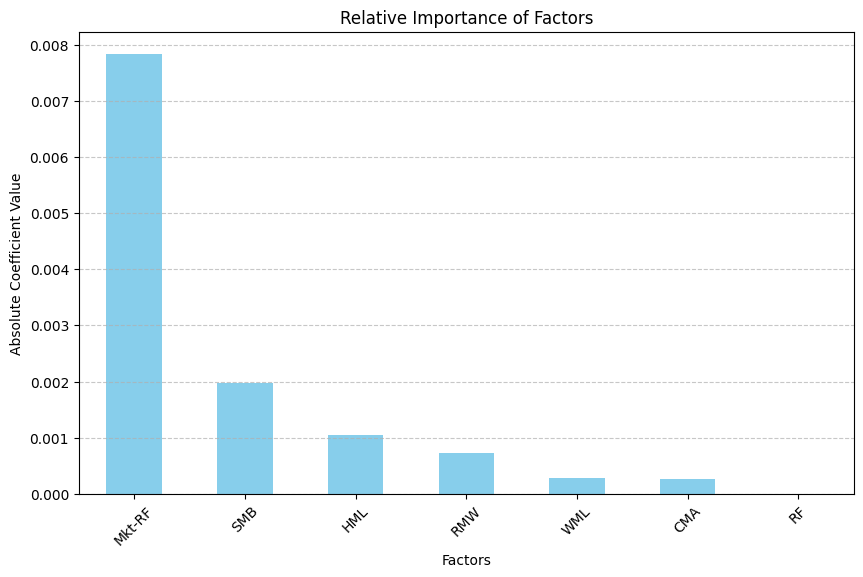

In [45]:
%matplotlib inline

import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- 1. Standardize the Factors ---
scaler = StandardScaler()
normalized_factors_train = scaler.fit_transform(aligned_ff_data_train)
normalized_factors_train = pd.DataFrame(normalized_factors_train, index=aligned_ff_data_train.index, columns=aligned_ff_data_train.columns)

# --- 2. Perform Regression ---
# Align SPY returns with normalized factors
model = sm.OLS(aligned_spy_returns_train, sm.add_constant(normalized_factors_train)).fit()

# Extract coefficients excluding the intercept
coefficients = model.params.drop('const')

# --- 3. Analyze t-Statistics ---
t_stats = model.tvalues.drop('const')

# Combine coefficients and t-statistics into a summary DataFrame
influence_summary = pd.DataFrame({
    'Coefficient': coefficients,
    't-Statistic': t_stats,
    'Abs(Coefficient)': coefficients.abs()
}).sort_values(by='Abs(Coefficient)', ascending=False)

# Display the summary
print("Factor Influence Summary:")
print(influence_summary)

# --- 4. Visualize Relative Importance ---
plt.figure(figsize=(10, 6))
influence_summary['Abs(Coefficient)'].plot(kind='bar', color='skyblue')
plt.title('Relative Importance of Factors')
plt.ylabel('Absolute Coefficient Value')
plt.xlabel('Factors')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [46]:
import pandas as pd
from ipywidgets import widgets, Output, Button
from IPython.display import display

# --- Combine Coefficients, RMSE, and Sector Information ---
# Merge RMSE with coefficients_df and include Sector data
coefficients_with_rmse = coefficients_df.merge(
    rmse_metrics[['Ticker', 'RMSE']],
    left_index=True,
    right_on='Ticker',
    how='inner'
).set_index('Ticker')

# Merge with sector information if not already merged
if 'Sector' not in coefficients_with_rmse.columns:
    coefficients_with_rmse = coefficients_with_rmse.merge(
        sector_info_df[['Sector']],
        left_index=True,
        right_index=True,
        how='left'
    )

# --- Normalize All Factors ---
def normalize_factors(data, columns):
    """Normalize each column to ensure all factors are on the same scale."""
    for column in columns:
        max_val = abs(data[column]).max()
        if max_val != 0:  # Avoid division by zero
            data[f"Normalized_{column}"] = data[column] / max_val
        else:
            data[f"Normalized_{column}"] = 0  # Set to zero if the column has no variation
    return data

# Normalize all coefficients and RMSE
columns_to_normalize = ["α (Daily Alpha)", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "WML", "RMSE"]
coefficients_with_rmse = normalize_factors(coefficients_with_rmse, columns_to_normalize)

# --- Compute Composite Scores ---
def compute_scores(data):
    """Compute composite scores using normalized factors and weights."""
    # Define weights for factors (provided weights)
    weights = {
        "Mkt-RF": 0.614,  # Reward market exposure
        "SMB": -0.206,    # Penalize small-cap exposure
        "HML": -0.084,    # Penalize value exposure
        "RMW": 0.065,     # Reward profitability
        "CMA": 0.021,     # Reward conservative investment
        "WML": 0.010      # Reward momentum
    }

    # Compute composite score
    data["Composite_Score"] = sum(
        weights[factor] * data[f"Normalized_{factor}"] for factor in weights
    )

    return data

# Apply the scoring function
scored_df = compute_scores(coefficients_with_rmse)

# --- Display Header and Interactive Show All ---
output = Output()

# Dropdown for sorting
sort_dropdown = widgets.Dropdown(
    options=["Composite_Score", "Sector"] + [col for col in scored_df.columns if not col.startswith("Normalized_")],
    description="Sort by:"
)
sort_order_checkbox = widgets.Checkbox(value=True, description="Ascending")

# Function to display header
def display_header():
    """Display the top-ranked stocks based on composite scores."""
    with output:
        output.clear_output(wait=True)
        header = scored_df.sort_values(by="Composite_Score", ascending=False).head(10)
        print("Top Stocks by Composite Score (Header):")
        display(header[[  # Display selected columns
            "Sector", "α (Daily Alpha)", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "WML", "RMSE", "Composite_Score"
        ]])

# Function to display all stocks with sorting
def display_all_stocks(b):
    """Display all stocks sorted by the selected column."""
    with output:
        output.clear_output(wait=True)
        sort_column = sort_dropdown.value
        sort_ascending = sort_order_checkbox.value
        print(f"All Stocks Sorted by {sort_column} ({'Ascending' if sort_ascending else 'Descending'}):")
        display(scored_df[[  # Display selected columns
            "Sector", "α (Daily Alpha)", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "WML", "RMSE", "Composite_Score"
        ]].sort_values(by=sort_column, ascending=sort_ascending))

# Button for showing all stocks
show_all_button = Button(description="Show All Stocks")
show_all_button.on_click(display_all_stocks)

# Display header, dropdown, and button
display_header()
display(widgets.HBox([sort_dropdown, sort_order_checkbox]), show_all_button, output)

Button(description='Show All Stocks', style=ButtonStyle())

Output()

In [47]:
import yfinance as yf
import pandas as pd
import numpy as np

def calculate_portfolio_sharpe(tickers, start_date, end_date, risk_free_rate=0.01):
    """
    Calculate the Sharpe Ratio for a portfolio with equal weights for each ticker.
    
    Args:
        tickers (list): List of ticker symbols.
        start_date (str): Start date for historical data.
        end_date (str): End date for historical data.
        risk_free_rate (float): Annualized risk-free rate (default: 1%).
    
    Returns:
        float: Portfolio Sharpe Ratio.
    """
    # Fetch adjusted close price data for the tickers
    price_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Calculate daily returns
    daily_returns = price_data.pct_change().dropna()
    
    # Calculate portfolio daily returns (equal weights)
    portfolio_returns = daily_returns.mean(axis=1)
    
    # Compute portfolio statistics
    mean_daily_return = portfolio_returns.mean()
    std_dev_daily_return = portfolio_returns.std()
    
    # Annualize returns and standard deviation
    trading_days = 252  # Approx. number of trading days in a year
    annualized_return = mean_daily_return * trading_days
    annualized_std_dev = std_dev_daily_return * np.sqrt(trading_days)
    
    # Calculate Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std_dev
    
    return sharpe_ratio

# Example usage
tickers = ["URI", "CLF", "ATI", "GNW", "GT", "FCX", "LYB", "CE", "FCPT", "X"]
start_date = "2016-01-01"
end_date = "2020-12-31"

sharpe_ratio = calculate_portfolio_sharpe(tickers, start_date, end_date)
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.4f}")


[*********************100%***********************]  10 of 10 completed

Portfolio Sharpe Ratio: 0.7403


[*********************100%***********************]  10 of 10 completed


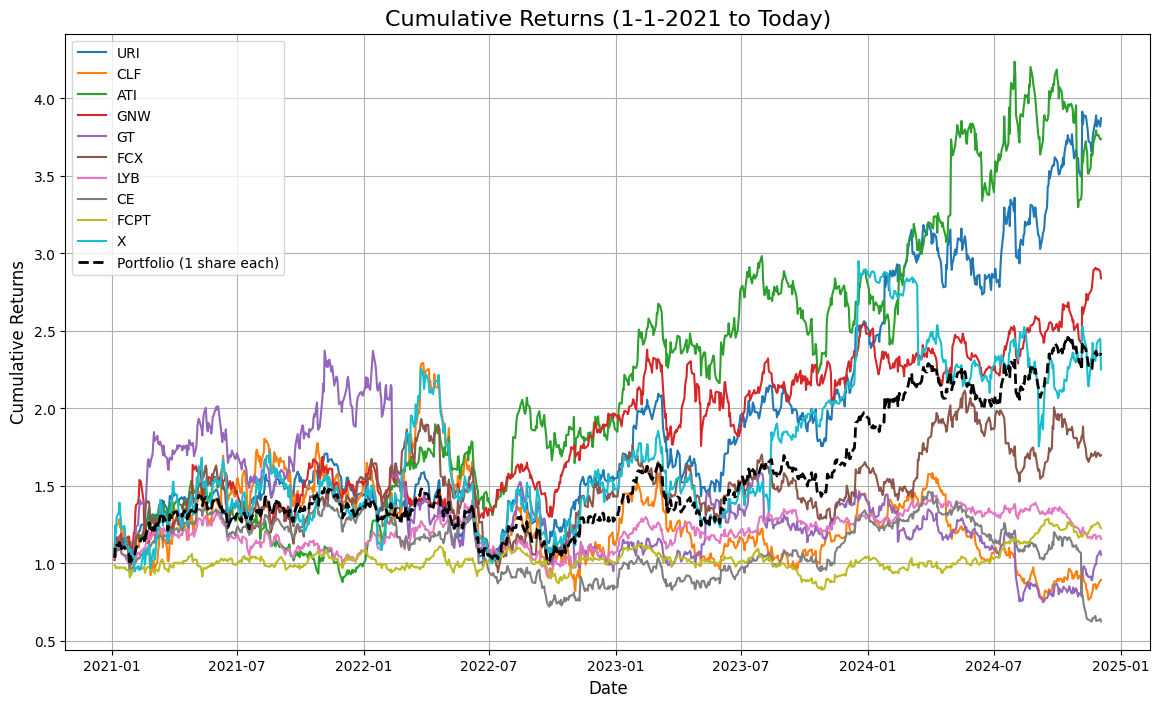

Beginning and Ending Prices for Each Ticker:
URI: Start Price = $224.41, End Price = $869.02
CLF: Start Price = $14.42, End Price = $12.90
ATI: Start Price = $15.98, End Price = $59.74
GNW: Start Price = $2.69, End Price = $7.64
GT: Start Price = $10.17, End Price = $10.74
FCX: Start Price = $25.79, End Price = $43.83
LYB: Start Price = $69.74, End Price = $80.78
CE: Start Price = $115.67, End Price = $72.50
FCPT: Start Price = $23.47, End Price = $28.83
X: Start Price = $16.72, End Price = $37.67

Portfolio started with owning 1 share of each stock (initial value = $519.06).
Portfolio value as of 2024-12-04: $1223.65
Total portfolio return: 135.74%


In [48]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# List of tickers
tickers = ["URI", "CLF", "ATI", "GNW", "GT", "FCX", "LYB", "CE", "FCPT", "X"]

# Define the time period
start_date = "2021-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

# Download adjusted closing prices for the tickers
data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]

# Calculate the beginning and ending prices for each ticker
beginning_prices = data.iloc[0]
ending_prices = data.iloc[-1]

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Calculate cumulative returns for each stock
cumulative_returns = (1 + daily_returns).cumprod()

# Calculate portfolio value based on initial investment as the sum of start prices
initial_portfolio_value = beginning_prices.sum()
portfolio_value = (cumulative_returns * beginning_prices).sum(axis=1)

# Plot cumulative returns for each stock
plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)
plt.plot(portfolio_value.index, portfolio_value / initial_portfolio_value, label="Portfolio (1 share each)", linewidth=2, color='black', linestyle='--')

# Add plot labels and legend
plt.title("Cumulative Returns (1-1-2021 to Today)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.grid()
plt.show()

# Print beginning and ending prices for each ticker
print("Beginning and Ending Prices for Each Ticker:")
for ticker in tickers:
    print(f"{ticker}: Start Price = ${beginning_prices[ticker]:.2f}, End Price = ${ending_prices[ticker]:.2f}")

# Print portfolio performance
portfolio_end_value = portfolio_value.iloc[-1]
portfolio_return = (portfolio_end_value - initial_portfolio_value) / initial_portfolio_value

print(f"\nPortfolio started with owning 1 share of each stock (initial value = ${initial_portfolio_value:.2f}).")
print(f"Portfolio value as of {end_date}: ${portfolio_end_value:.2f}")
print(f"Total portfolio return: {portfolio_return:.2%}")